In [287]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from transformers import pipeline
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

In [ ]:
# Submissions
sub_pre_df = pd.read_csv("../../work/FCSS/LIWC-22 Results_anxiety_submission_pre_covid.csv")
sub_post_df =  pd.read_csv("../../work/FCSS/LIWC-22 Results_anxiety_submission_post_covid.csv")

# Comments
coms_pre_df = pd.read_csv("../../work/FCSS/LIWC-22 Results_anxiety_comments_pre_covid.csv")
coms_post_df =  pd.read_csv("../../work/FCSS/LIWC-22 Results_anxiety_comments_post_covid.csv")

# LIWC Reddit Baseline
baseline_df = pd.DataFrame(pd.read_excel("../../data/thomas_MH/LIWC/LIWC-22-Baseline-Reddit.xlsx"))
baseline_df

# Final Files

In [164]:
# Submissions
sub_pre_df = pd.read_csv("../../work/FCSS/submission_pre_covid_sentiment.csv")
sub_post_df =  pd.read_csv("../../work/FCSS/submission_post_covid_sentiment.csv")

# Comments
coms_pre_df = pd.read_csv("../../work/FCSS/comments_pre_covid_sentiment.csv")
coms_post_df =  pd.read_csv("../../work/FCSS/comments_post_covid_sentiment.csv")

# Check for NaN

In [296]:
print(sub_pre_df[['VADER_compound', 'Tone']].isnull().sum())
print(sub_post_df[['VADER_compound', 'Tone']].isnull().sum())

print(coms_pre_df[['VADER_compound', 'Tone']].isnull().sum())
print(coms_post_df[['VADER_compound', 'Tone']].isnull().sum())

VADER_compound    0
Tone              0
BERT_label        0
dtype: int64
VADER_compound    0
Tone              0
dtype: int64
VADER_compound    0
Tone              0
dtype: int64
VADER_compound    0
Tone              0
dtype: int64


In [149]:
# Fill NaN values in Tone with 50 (neutral)
sub_pre_df['Tone'].fillna(50, inplace=True)
sub_post_df['Tone'].fillna(50, inplace=True)
coms_pre_df['Tone'].fillna(50, inplace=True)
coms_post_df['Tone'].fillna(50, inplace=True)

In [166]:
# Drop rows with NaN in Tone and VADER_compound
sub_pre_df.dropna(subset=['Tone', 'VADER_compound'], inplace=True)
sub_post_df.dropna(subset=['Tone', 'VADER_compound'], inplace=True)
coms_pre_df.dropna(subset=['Tone', 'VADER_compound'], inplace=True)
coms_post_df.dropna(subset=['Tone', 'VADER_compound'], inplace=True)

In [294]:
sub_pre_df

,author,created_utc,id,num_comments,num_crossposts,permalink,subreddit,title,ColumnID,Text,...,Apostro,OtherP,Emoji,VADER_compound,VADER_scaled,BERT_sentiment,BERT_label,BERT_score,LIWC_Sentiment,VADER_Sentiment
0,welcomenope,2018-01-01 00:01:12,7nby40,2.0,0.0,/r/Anxiety/comments/7nby40/my_mom_is_crying_be...,Anxiety,My Mom is crying because i refused to call to ...,selftext,My Mom is crying because i refused to call to ...,...,6.70,2.39,0.0,-0.9480,2.595260,"('NEGATIVE', 0.9978119134902954)",NEGATIVE,0.997812,Negative,Negative
1,Sqrqol,2018-01-01 00:17:23,7nc19c,5.0,0.0,/r/Anxiety/comments/7nc19c/how_to_deal_with_he...,Anxiety,How to deal with 'heart attacks' every night?,selftext,How to deal with 'heart attacks' every night?\...,...,16.67,0.00,0.0,-0.0258,48.709871,"('NEGATIVE', 0.9984802603721619)",NEGATIVE,0.998480,Negative,Neutral
2,CaptainCarlyle,2018-01-01 02:15:15,7ncmtd,11.0,0.0,/r/Anxiety/comments/7ncmtd/how_does_it_feel_to...,Anxiety,How does it feel to not have anxiety?,selftext,How does it feel to not have anxiety?\n I've h...,...,2.02,0.00,0.0,-0.9647,1.760176,"('POSITIVE', 0.9808213710784912)",POSITIVE,0.980821,Negative,Negative
3,atc05040,2018-01-01 02:35:18,7ncq8n,5.0,0.0,/r/Anxiety/comments/7ncq8n/i_could_do_with_som...,Anxiety,I could do with some advice. Im really struggl...,selftext,I could do with some advice. Im really struggl...,...,5.82,0.00,0.0,-0.9823,0.880088,"('NEGATIVE', 0.9890487194061279)",NEGATIVE,0.989049,Negative,Negative
4,leonardfurnstein,2018-01-01 02:35:53,7ncqd7,4.0,0.0,/r/Anxiety/comments/7ncqd7/stuck_at_a_party/,Anxiety,Stuck at a party,selftext,Stuck at a party\nI’m at a completely fine NYE...,...,5.97,1.99,0.0,0.9258,96.294629,"('NEGATIVE', 0.9993731379508972)",NEGATIVE,0.999373,Neutral,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96133,kausarahmad,2019-12-31 23:05:45,eiabo7,15.0,0.0,/r/Anxiety/comments/eiabo7/does_anyone_else_ha...,Anxiety,"Does anyone else have chest pain, not just dur...",selftext,"Does anyone else have chest pain, not just dur...",...,2.63,0.00,0.0,-0.8976,5.115512,"('NEGATIVE', 0.9839063882827759)",NEGATIVE,0.983906,Negative,Negative
96134,tyrantshelpedbuildus,2019-12-31 23:14:05,eiafhw,32.0,0.0,/r/Anxiety/comments/eiafhw/anyone_else_feel_de...,Anxiety,Anyone else feel depressed and anxious every n...,selftext,Anyone else feel depressed and anxious every n...,...,4.65,2.33,0.0,-0.7149,14.251425,"('NEGATIVE', 0.9980019927024841)",NEGATIVE,0.998002,Negative,Negative
96135,godnorc,2019-12-31 23:41:40,eiarx1,2.0,0.0,/r/Anxiety/comments/eiarx1/i_am_not_ready_for_...,Anxiety,I am not ready for the new year,selftext,I am not ready for the new year\nIt just came ...,...,3.97,0.00,0.0,-0.5505,22.472247,"('NEGATIVE', 0.9923126101493835)",NEGATIVE,0.992313,Positive,Negative
96136,ParanoidAndroid353,2019-12-31 23:44:35,eiat50,1.0,0.0,/r/Anxiety/comments/eiat50/is_this_technically...,Anxiety,Is this technically Anxiety?,selftext,Is this technically Anxiety?\nI've had issues ...,...,6.24,3.85,0.0,0.7044,85.223522,"('NEGATIVE', 0.9523388147354126)",NEGATIVE,0.952339,Negative,Positive


# LIWC Sentiment (Tone)

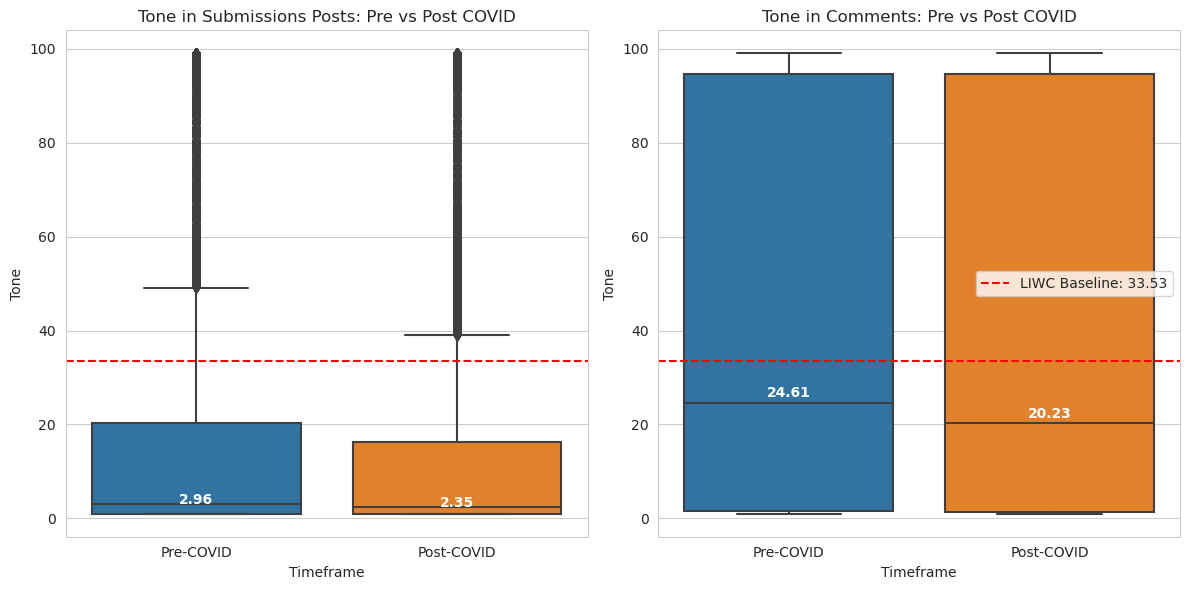

In [167]:
baseline_tone = baseline_df[baseline_df['LIWC-22-Stats'] == 'Tone']['Mean'].values[0]
sns.set_style("whitegrid")

# DF Pre and Post Covid for submissions and comments
sub_data = pd.DataFrame({
    'Tone': pd.concat([sub_pre_df['Tone'], sub_post_df['Tone']]),
    'Timeframe': ['Pre-COVID'] * len(sub_pre_df) + ['Post-COVID'] * len(sub_post_df)
})

coms_data = pd.DataFrame({
    'Tone': pd.concat([coms_pre_df['Tone'], coms_post_df['Tone']]),
    'Timeframe': ['Pre-COVID'] * len(coms_pre_df) + ['Post-COVID'] * len(coms_post_df)
})


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
box_plot_sub = sns.boxplot(x='Timeframe', y='Tone', data=sub_data)
plt.axhline(y=baseline_tone, color='red', linestyle='--', label='LIWC Baseline: 33.53')  # Add red baseline line
plt.title('Tone in Submissions Posts: Pre vs Post COVID')

median_pre_sub = sub_pre_df['Tone'].median()
median_post_sub = sub_post_df['Tone'].median()

# calc vertical offset for annotation (for a better viz)
vertical_offset_sub = sub_pre_df['Tone'].median() * 0.05

# annotation of medians on the boxplot
box_plot_sub.text(0, median_pre_sub + vertical_offset_sub, 
                  f'{median_pre_sub:.2f}', 
                  horizontalalignment='center', size='medium', color='white', weight='semibold')
box_plot_sub.text(1, median_post_sub + vertical_offset_sub, 
                  f'{median_post_sub:.2f}', 
                  horizontalalignment='center', size='medium', color='white', weight='semibold')

# boxplot for comments tone (Pre vs Post)
plt.subplot(1, 2, 2)
box_plot_coms = sns.boxplot(x='Timeframe', y='Tone', data=coms_data)
# adds the red line based on the LIWC baseline
plt.axhline(y=baseline_tone, color='red', linestyle='--', label='LIWC Baseline: 33.53')
plt.title('Tone in Comments: Pre vs Post COVID')

median_pre_coms = coms_pre_df['Tone'].median()
median_post_coms = coms_post_df['Tone'].median()

# calc offset again
vertical_offset_coms = coms_pre_df['Tone'].median() * 0.05

# annotation of medians on the boxplot
box_plot_coms.text(0, median_pre_coms + vertical_offset_coms, 
                   f'{median_pre_coms:.2f}', 
                   horizontalalignment='center', size='medium', color='white', weight='semibold')
box_plot_coms.text(1, median_post_coms + vertical_offset_coms, 
                   f'{median_post_coms:.2f}', 
                   horizontalalignment='center', size='medium', color='white', weight='semibold')

plt.legend()
plt.tight_layout()
plt.savefig('../../work/FCSS/LIWC_sentiment_comparison_boxplot.png', format='png', dpi=300)
plt.show()

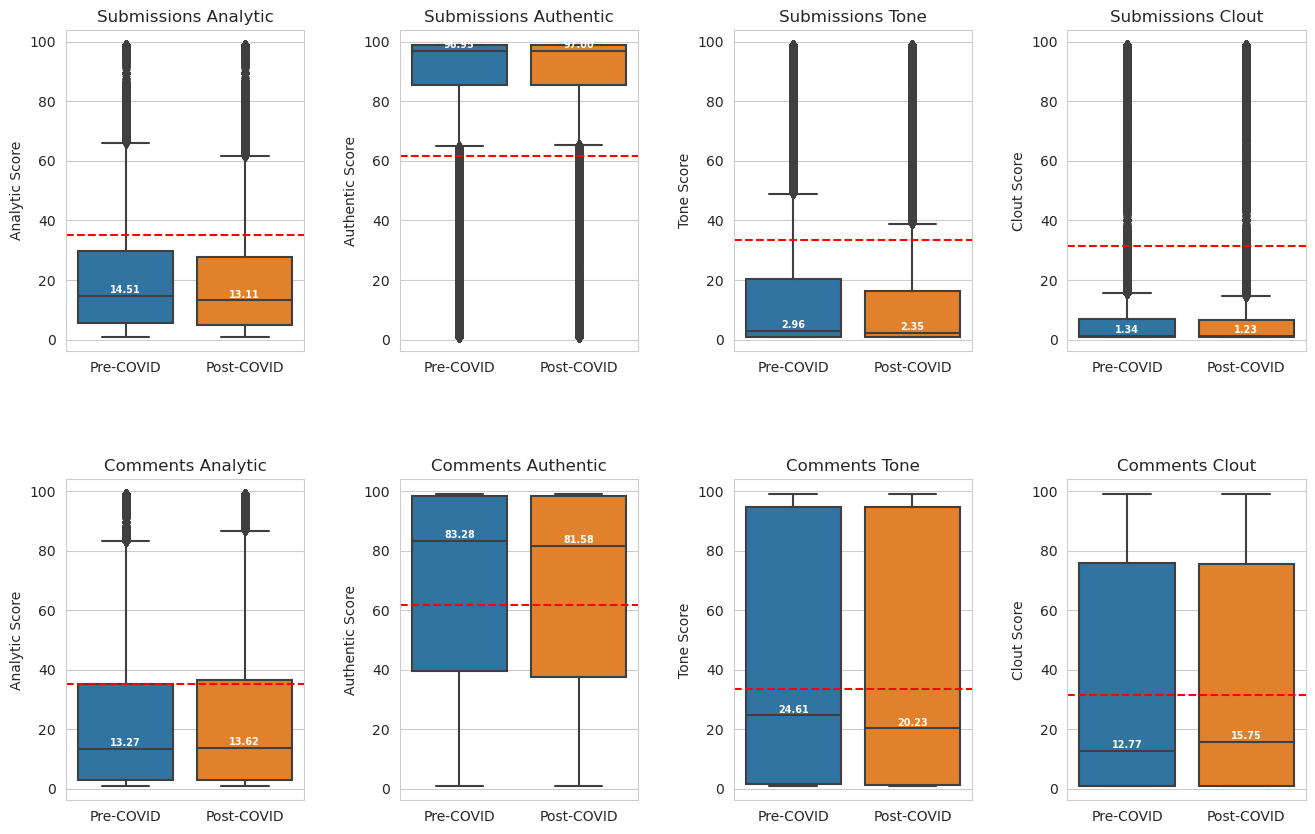

In [297]:
# List of LIWC dimensions to visualize
liwc_dimensions = ['Analytic', 'Authentic', 'Tone', 'Clout']

# Extract baseline values for these dimensions
baseline_values = baseline_df.set_index('LIWC-22-Stats').loc[liwc_dimensions, 'Mean'].to_dict()

fig, axes = plt.subplots(2, 4, figsize=(16, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

def plot_liwc_dimension(ax, pre_data, post_data, dimension, title_prefix):
    sns.boxplot(data=[pre_data[dimension], post_data[dimension]], ax=ax)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Pre-COVID', 'Post-COVID'])
    ax.set_title(f'{title_prefix} {dimension}')
    ax.set_ylabel(f'{dimension} Score')
    ax.axhline(y=baseline_values[dimension], color='red', linestyle='--', label=f'Baseline: {baseline_values[dimension]:.2f}')

    # calc and annotate medians
    medians = [pre_data[dimension].median(), post_data[dimension].median()]
    for xtick, median in enumerate(medians):
        ax.text(xtick, median + 1, f'{median:.2f}', 
                horizontalalignment='center', size='x-small', color='white', weight='semibold')

# submissions
for i, dimension in enumerate(liwc_dimensions):
    plot_liwc_dimension(axes[0, i], sub_pre_df, sub_post_df, dimension, 'Submissions')

# comments
for i, dimension in enumerate(liwc_dimensions):
    plot_liwc_dimension(axes[1, i], coms_pre_df, coms_post_df, dimension, 'Comments')

plt.savefig('../../work/FCSS/LIWC_summary_measures_comparison_boxplot.png', format='png', dpi=300)
    
plt.show()

# Categorize LIWC Sentiment (TONE)

In [169]:
liwc_bins = [0, 40, 60, 100]  # Neutral is between 45 and 55
liwc_labels = ['Negative', 'Neutral', 'Positive']

# Submissions
sub_pre_df['LIWC_Sentiment'] = pd.cut(sub_pre_df['Tone'], bins=liwc_bins, labels=liwc_labels)
sub_post_df['LIWC_Sentiment'] = pd.cut(sub_post_df['Tone'], bins=liwc_bins, labels=liwc_labels)

# Comments
coms_pre_df['LIWC_Sentiment'] = pd.cut(coms_pre_df['Tone'], bins=liwc_bins, labels=liwc_labels)
coms_post_df['LIWC_Sentiment'] = pd.cut(coms_post_df['Tone'], bins=liwc_bins, labels=liwc_labels)

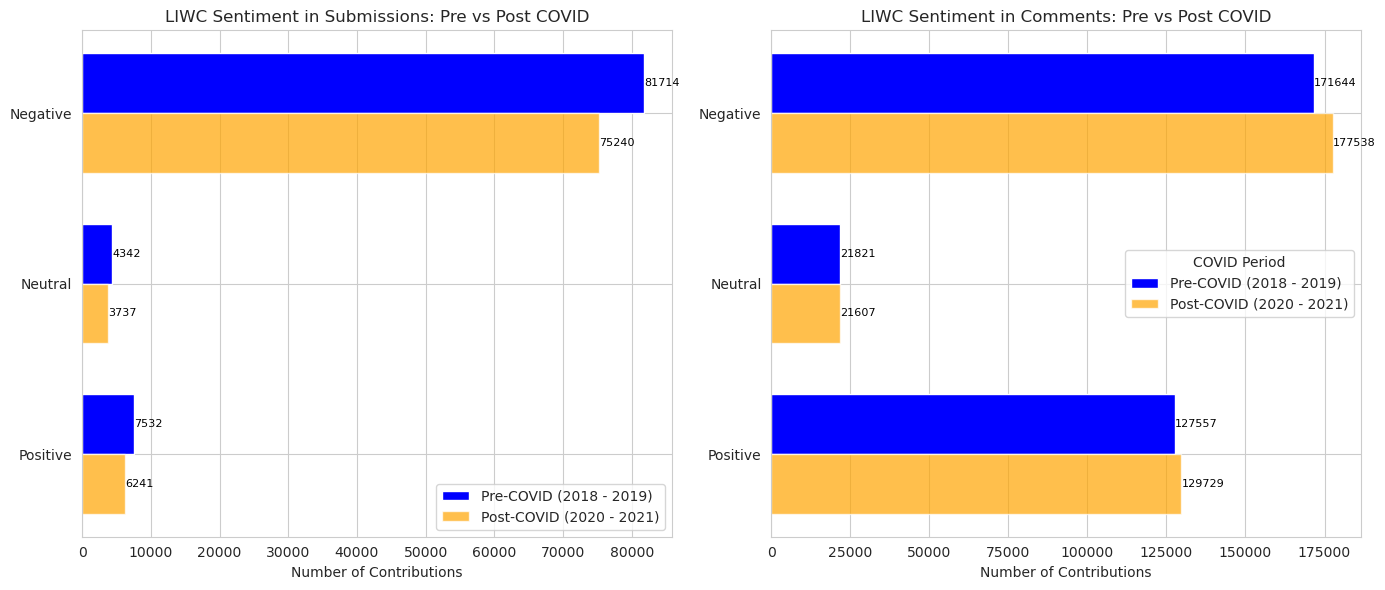

In [298]:
pre_covid_color = 'blue'
post_covid_color = 'orange'

sns.set_style("whitegrid")

index = np.arange(3)
bar_width = 0.35

# Plot for Submissions and Comments
plt.figure(figsize=(14, 6))

# Submissions
plt.subplot(1, 2, 1)
pre_liwc_counts = sub_pre_df['LIWC_Sentiment'].value_counts().reindex(['Positive', 'Neutral', 'Negative'], fill_value=0)
post_liwc_counts = sub_post_df['LIWC_Sentiment'].value_counts().reindex(['Positive', 'Neutral', 'Negative'], fill_value=0)

plt.barh(index + bar_width / 2, pre_liwc_counts.values, bar_width, color=pre_covid_color, label='Pre-COVID (2018 - 2019)')
# plt.barh(index - bar_width / 2, post_liwc_counts.values, bar_width, edgecolor='black', linewidth=1.5, color=post_covid_color, alpha=0.7, label='Post-COVID (2020 - 2021)')
plt.barh(index - bar_width / 2, post_liwc_counts.values, bar_width, color=post_covid_color, alpha=0.7, label='Post-COVID (2020 - 2021)')

# adding values on bars
for i, value in enumerate(pre_liwc_counts.values):
    plt.text(value + 50, index[i] + bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')
for i, value in enumerate(post_liwc_counts.values):
    plt.text(value + 50, index[i] - bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')

plt.yticks(index, pre_liwc_counts.index)
plt.title('LIWC Sentiment in Submissions: Pre vs Post COVID')
plt.xlabel('Number of Contributions')
plt.legend()

# Comments
plt.subplot(1, 2, 2)
pre_liwc_counts_com = coms_pre_df['LIWC_Sentiment'].value_counts().reindex(['Positive', 'Neutral', 'Negative'], fill_value=0)
post_liwc_counts_com = coms_post_df['LIWC_Sentiment'].value_counts().reindex(['Positive', 'Neutral', 'Negative'], fill_value=0)

plt.barh(index + bar_width / 2, pre_liwc_counts_com.values, bar_width, color=pre_covid_color, label='Pre-COVID (2018 - 2019)')
# plt.barh(index - bar_width / 2, post_liwc_counts_com.values, bar_width, edgecolor='black', linewidth=1.5, color=post_covid_color, alpha=0.7, label='Post-COVID (2020 - 2021)')
plt.barh(index - bar_width / 2, post_liwc_counts_com.values, bar_width, color=post_covid_color, alpha=0.7, label='Post-COVID (2020 - 2021)')

# values on bars
for i, value in enumerate(pre_liwc_counts_com.values):
    plt.text(value + 50, index[i] + bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')
for i, value in enumerate(post_liwc_counts_com.values):
    plt.text(value + 50, index[i] - bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')

plt.yticks(index, pre_liwc_counts_com.index)
plt.title('LIWC Sentiment in Comments: Pre vs Post COVID')
plt.xlabel('Number of Contributions')
plt.legend(title="COVID Period")

# Adjust layout and show plot
plt.tight_layout()

plt.savefig('../../work/FCSS/LIWC_sentiment_comparison.png', format='png', dpi=300)

plt.show()


# Vader Sentiment - MinMax Scaled to fit LIWC Tone

In [163]:
analyzer = SentimentIntensityAnalyzer()
scaler = MinMaxScaler(feature_range=(0, 1))

def get_vader_compound_score(text):
    return float(analyzer.polarity_scores(text)['compound'])

# Just to be safe
sub_pre_df['Text'] = sub_pre_df['Text'].astype(str)
sub_post_df['Text'] = sub_post_df['Text'].astype(str)
coms_pre_df['Text'] = coms_pre_df['Text'].astype(str)
coms_post_df['Text'] = coms_post_df['Text'].astype(str)


# Submissions
sub_pre_df['VADER_compound'] = sub_pre_df['Text'].apply(get_vader_compound_score)
sub_post_df['VADER_compound'] = sub_post_df['Text'].apply(get_vader_compound_score)

# Comments
coms_pre_df['VADER_compound'] = coms_pre_df['Text'].apply(get_vader_compound_score)
coms_post_df['VADER_compound'] = coms_post_df['Text'].apply(get_vader_compound_score)

# concat all dataframes for scaling (Submissions + Comments)
combined_df = pd.concat([sub_pre_df[['VADER_compound']], sub_post_df[['VADER_compound']], coms_pre_df[['VADER_compound']], coms_post_df[['VADER_compound']]])

# Fit the scaler on the combined data so that the minmax scaling is correct based on the WHOLE vader_compound data.
scaler.fit(combined_df[['VADER_compound']])

# Min Max Scaling to fit LIWC Dimensions 0-100 insead of -1 to 1
sub_pre_df['VADER_scaled'] = scaler.fit_transform(sub_pre_df[['VADER_compound']]) * 100
print('Submissions Pre-Covid DONE')
sub_post_df['VADER_scaled'] = scaler.fit_transform(sub_post_df[['VADER_compound']]) * 100
print('Submissions Post-Covid DONE')
coms_pre_df['VADER_scaled'] = scaler.fit_transform(coms_pre_df[['VADER_compound']]) * 100
print('Comments Pre-Covid DONE')
coms_post_df['VADER_scaled'] = scaler.fit_transform(coms_post_df[['VADER_compound']]) * 100
print('Comments Post-Covid DONE')


KeyboardInterrupt: 

In [171]:
sub_pre_df[['subreddit', 'Text', 'Tone', 'VADER_scaled', 'VADER_compound']]

,subreddit,Text,Tone,VADER_scaled,VADER_compound
0,Anxiety,My Mom is crying because i refused to call to ...,1.96,2.595260,-0.9480
1,Anxiety,How to deal with 'heart attacks' every night?\...,1.00,48.709871,-0.0258
2,Anxiety,How does it feel to not have anxiety?\n I've h...,1.00,1.760176,-0.9647
3,Anxiety,I could do with some advice. Im really struggl...,2.26,0.880088,-0.9823
4,Anxiety,Stuck at a party\nI’m at a completely fine NYE...,50.81,96.294629,0.9258
...,...,...,...,...,...
96133,Anxiety,"Does anyone else have chest pain, not just dur...",1.00,5.115512,-0.8976
96134,Anxiety,Anyone else feel depressed and anxious every n...,3.38,14.251425,-0.7149
96135,Anxiety,I am not ready for the new year\nIt just came ...,70.15,22.472247,-0.5505
96136,Anxiety,Is this technically Anxiety?\nI've had issues ...,16.08,85.223522,0.7044


# Visualize VADER Sentiment (MIN MAX SCALED)

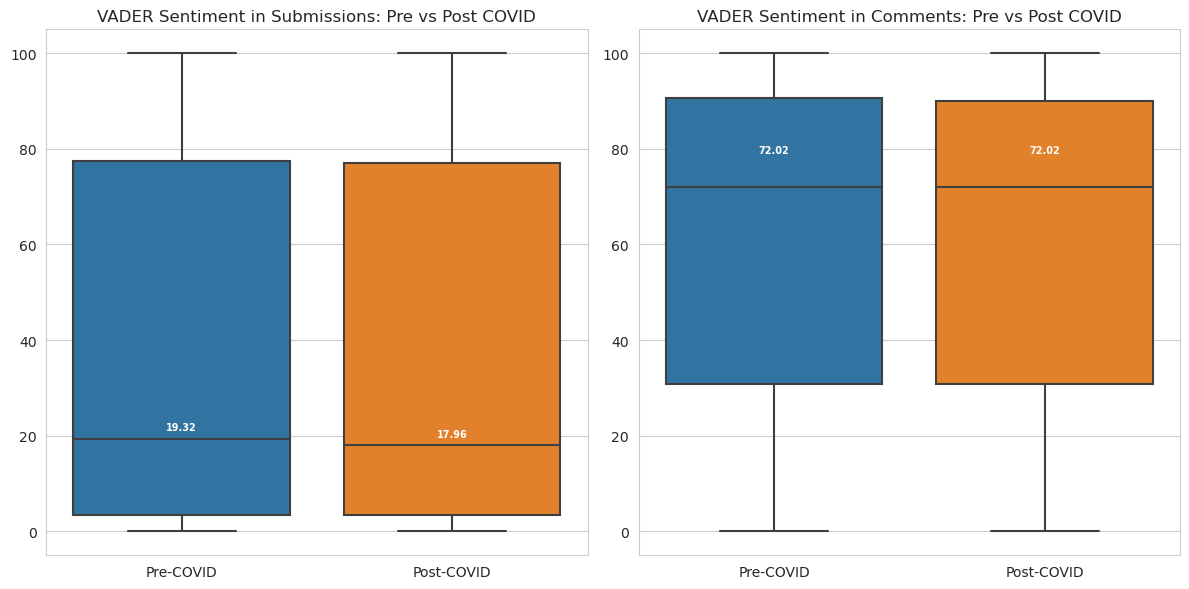

In [301]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Submissions
plt.subplot(1, 2, 1)
box_plot_sub = sns.boxplot(data=[sub_pre_df['VADER_scaled'], sub_post_df['VADER_scaled']])
plt.xticks([0, 1], ['Pre-COVID', 'Post-COVID'])
plt.title('VADER Sentiment in Submissions: Pre vs Post COVID')

# calc medians for annotation
medians_sub = [sub_pre_df['VADER_scaled'].median(), sub_post_df['VADER_scaled'].median()]
vertical_offset_sub = (sub_pre_df['VADER_scaled'].median() + sub_post_df['VADER_scaled'].median()) * 0.05

# annotation median values
for xtick in [0, 1]:
    plt.text(xtick, medians_sub[xtick] + vertical_offset_sub, f'{medians_sub[xtick]:.2f}', 
             horizontalalignment='center', size='x-small', color='white', weight='semibold')

# Comments
plt.subplot(1, 2, 2)
box_plot_coms = sns.boxplot(data=[coms_pre_df['VADER_scaled'], coms_post_df['VADER_scaled']])
plt.xticks([0, 1], ['Pre-COVID', 'Post-COVID'])
plt.title('VADER Sentiment in Comments: Pre vs Post COVID')

# calc medians for annotation
medians_coms = [coms_pre_df['VADER_scaled'].median(), coms_post_df['VADER_scaled'].median()]
vertical_offset_coms = (coms_pre_df['VADER_scaled'].median() + coms_post_df['VADER_scaled'].median()) * 0.05

# annotation median values
for xtick in [0, 1]:
    plt.text(xtick, medians_coms[xtick] + vertical_offset_coms, f'{medians_coms[xtick]:.2f}', 
             horizontalalignment='center', size='x-small', color='white', weight='semibold')

plt.tight_layout()
plt.savefig('../../work/FCSS/VADER_sentiment_comparison_boxplot.png', format='png', dpi=300)
plt.show()

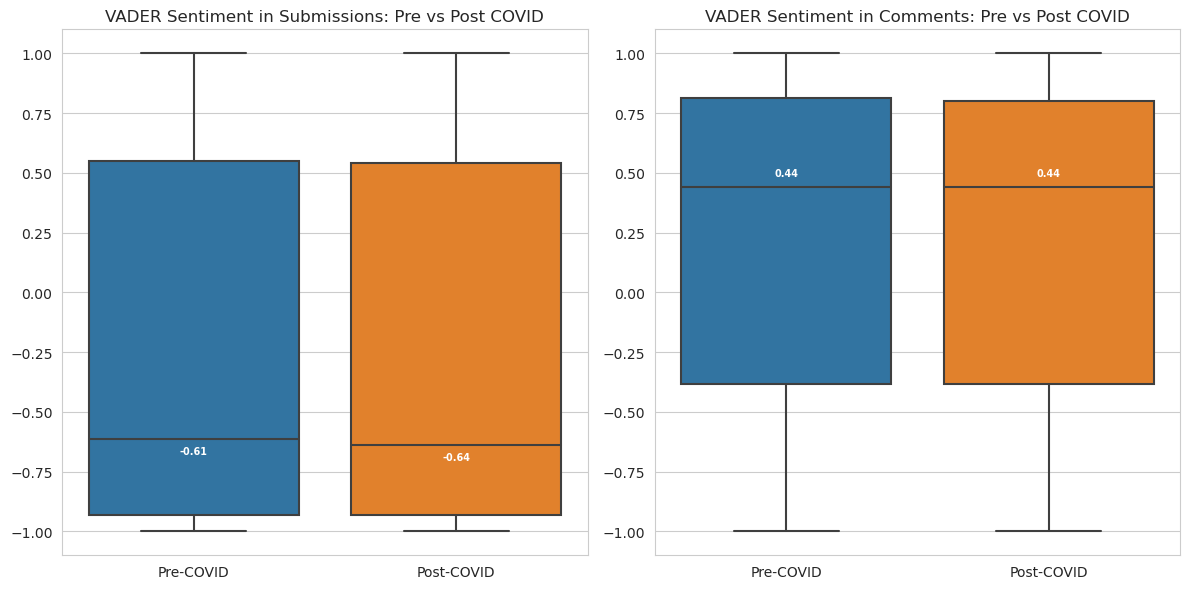

In [174]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Submissions
plt.subplot(1, 2, 1)
box_plot_sub = sns.boxplot(data=[sub_pre_df['VADER_compound'], sub_post_df['VADER_compound']])
plt.xticks([0, 1], ['Pre-COVID', 'Post-COVID'])
plt.title('VADER Sentiment in Submissions: Pre vs Post COVID')

# clac medians for annotation
medians_sub = [sub_pre_df['VADER_compound'].median(), sub_post_df['VADER_compound'].median()]
vertical_offset_sub = (sub_pre_df['VADER_compound'].median() + sub_post_df['VADER_compound'].median()) * 0.05

# annotation median values
for xtick in [0, 1]:
    plt.text(xtick, medians_sub[xtick] + vertical_offset_sub, f'{medians_sub[xtick]:.2f}', 
             horizontalalignment='center', size='x-small', color='white', weight='semibold')

# Comments
plt.subplot(1, 2, 2)
box_plot_coms = sns.boxplot(data=[coms_pre_df['VADER_compound'], coms_post_df['VADER_compound']])
plt.xticks([0, 1], ['Pre-COVID', 'Post-COVID'])
plt.title('VADER Sentiment in Comments: Pre vs Post COVID')

# calc medians for annotation
medians_coms = [coms_pre_df['VADER_compound'].median(), coms_post_df['VADER_compound'].median()]
vertical_offset_coms = (coms_pre_df['VADER_compound'].median() + coms_post_df['VADER_compound'].median()) * 0.05

# annotation median values
for xtick in [0, 1]:
    plt.text(xtick, medians_coms[xtick] + vertical_offset_coms, f'{medians_coms[xtick]:.2f}', 
             horizontalalignment='center', size='x-small', color='white', weight='semibold')

plt.tight_layout()
plt.show()

# Check Vader Similarity in Comments

In [176]:
print("Pre-COVID Comments VADER Compound Summary:")
print(coms_pre_df['VADER_compound'].describe())
print("\nPost-COVID Comments VADER Compound Summary:")
print(coms_post_df['VADER_compound'].describe())

print("Unique values in Pre-COVID comments:")
print(coms_pre_df['VADER_compound'].unique())
print("\nUnique values in Post-COVID comments:")
print(coms_post_df['VADER_compound'].unique())

print(f"Number of rows in Pre-COVID comments: {len(coms_pre_df)}")
print(f"Number of rows in Post-COVID comments: {len(coms_post_df)}")

Pre-COVID Comments VADER Compound Summary:
count    321022.000000
mean          0.227205
std           0.649452
min          -0.999900
25%          -0.381800
50%           0.440400
75%           0.811900
max           0.999900
Name: VADER_compound, dtype: float64

Post-COVID Comments VADER Compound Summary:
count    328874.000000
mean          0.225839
std           0.645772
min          -0.999900
25%          -0.381800
50%           0.440400
75%           0.802000
max           1.000000
Name: VADER_compound, dtype: float64
Unique values in Pre-COVID comments:
[ 0.9081 -0.2815  0.     ...  0.535   0.1482  0.0858]

Unique values in Post-COVID comments:
[-0.1615 -0.7251  0.7906 ...  0.2877  0.3932 -0.4346]
Number of rows in Pre-COVID comments: 321022
Number of rows in Post-COVID comments: 328874


In [178]:
coms_pre_df['VADER_Sentiment'] = pd.cut(coms_pre_df['VADER_compound'], bins=[-1, -0.5, 0.5, 1], labels=['Negative', 'Neutral', 'Positive'])
coms_post_df['VADER_Sentiment'] = pd.cut(coms_post_df['VADER_compound'], bins=[-1, -0.5, 0.5, 1], labels=['Negative', 'Neutral', 'Positive'])

print("Pre-COVID Sentiment Distribution:")
print(coms_pre_df['VADER_Sentiment'].value_counts(normalize=True))
print("\nPost-COVID Sentiment Distribution:")
print(coms_post_df['VADER_Sentiment'].value_counts(normalize=True))

Pre-COVID Sentiment Distribution:
VADER_Sentiment
Positive    0.466195
Neutral     0.320395
Negative    0.213409
Name: proportion, dtype: float64

Post-COVID Sentiment Distribution:
VADER_Sentiment
Positive    0.46388
Neutral     0.32472
Negative    0.21140
Name: proportion, dtype: float64


In [179]:
stat, p = mannwhitneyu(coms_pre_df['VADER_compound'], coms_post_df['VADER_compound'])
print(f'Mann-Whitney U Test: Statistic={stat}, p-value={p}')
if p < 0.05:
    print("The sentiment distributions are significantly different.")
else:
    print("No significant difference in sentiment distributions.")

Mann-Whitney U Test: Statistic=53007685281.5, p-value=0.0036528930713773736
The sentiment distributions are significantly different.


# Categorize VADER Sentiment

In [180]:
# Updated vader_bins matching VADER documentation thresholds
# Negative <= -0.5, -0.5 < Neutral < 0.5, Positive >= 0.5
vader_bins = [-1, -0.5, 0.5, 1]  
vader_labels = ['Negative', 'Neutral', 'Positive']

# Ensure binning includes right-side boundaries
sub_pre_df['VADER_Sentiment'] = pd.cut(sub_pre_df['VADER_compound'], bins=vader_bins, labels=vader_labels, right=True, include_lowest=True)
sub_post_df['VADER_Sentiment'] = pd.cut(sub_post_df['VADER_compound'], bins=vader_bins, labels=vader_labels, right=True, include_lowest=True)

coms_pre_df['VADER_Sentiment'] = pd.cut(coms_pre_df['VADER_compound'], bins=vader_bins, labels=vader_labels, right=True, include_lowest=True)
coms_post_df['VADER_Sentiment'] = pd.cut(coms_post_df['VADER_compound'], bins=vader_bins, labels=vader_labels, right=True, include_lowest=True)

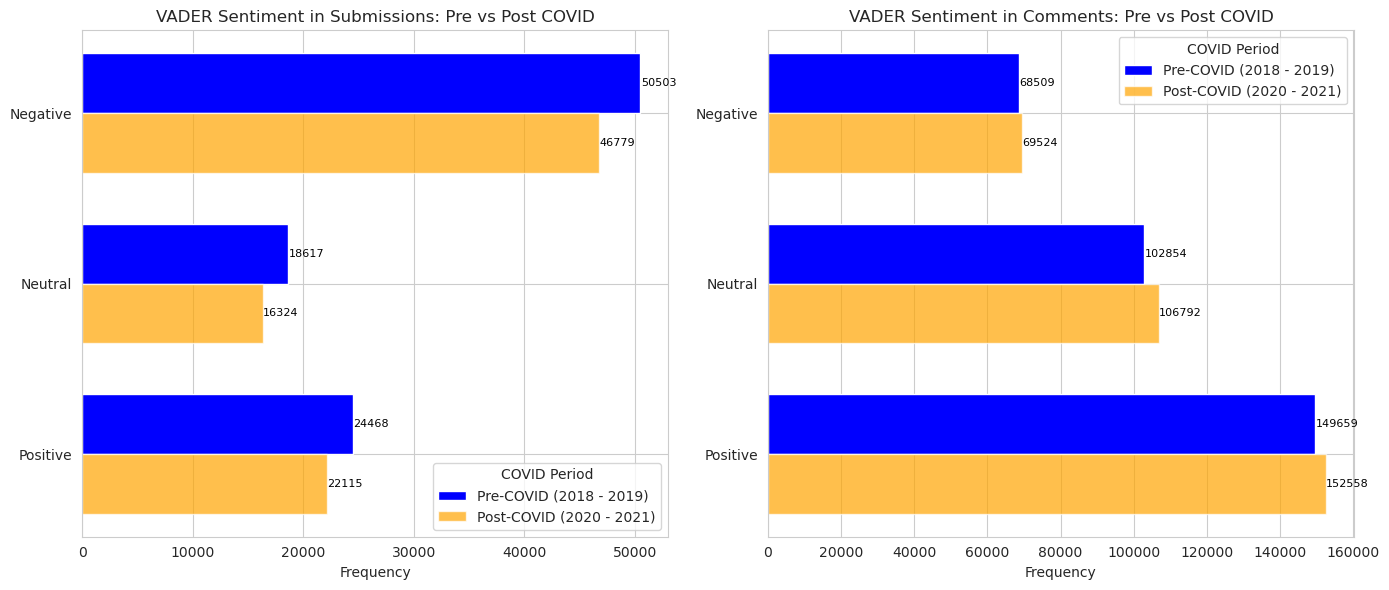

In [300]:
pre_covid_color = 'blue'
post_covid_color = 'orange'

sns.set_style("whitegrid")

index = np.arange(3)
bar_width = 0.35

plt.figure(figsize=(14, 6))

# Submissions
plt.subplot(1, 2, 1)
pre_vader_counts = sub_pre_df['VADER_Sentiment'].value_counts().reindex(['Positive', 'Neutral', 'Negative'], fill_value=0)
post_vader_counts = sub_post_df['VADER_Sentiment'].value_counts().reindex(['Positive', 'Neutral', 'Negative'], fill_value=0)

plt.barh(index + bar_width / 2, pre_vader_counts.values, bar_width, color=pre_covid_color, label='Pre-COVID (2018 - 2019)')
plt.barh(index - bar_width / 2, post_vader_counts.values, bar_width, color=post_covid_color, alpha=0.7, label='Post-COVID (2020 - 2021)')

for i, value in enumerate(pre_vader_counts.values):
    plt.text(value + 50, index[i] + bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')
for i, value in enumerate(post_vader_counts.values):
    plt.text(value + 50, index[i] - bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')

plt.yticks(index, pre_vader_counts.index)
plt.title('VADER Sentiment in Submissions: Pre vs Post COVID')
plt.xlabel('Frequency')
plt.legend(title="COVID Period")

# Comments
plt.subplot(1, 2, 2)
pre_vader_counts_com = coms_pre_df['VADER_Sentiment'].value_counts().reindex(['Positive', 'Neutral', 'Negative'], fill_value=0)
post_vader_counts_com = coms_post_df['VADER_Sentiment'].value_counts().reindex(['Positive', 'Neutral', 'Negative'], fill_value=0)

plt.barh(index + bar_width / 2, pre_vader_counts_com.values, bar_width, color=pre_covid_color, label='Pre-COVID (2018 - 2019)')
plt.barh(index - bar_width / 2, post_vader_counts_com.values, bar_width, color=post_covid_color, alpha=0.7, label='Post-COVID (2020 - 2021)')

for i, value in enumerate(pre_vader_counts_com.values):
    plt.text(value + 50, index[i] + bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')
for i, value in enumerate(post_vader_counts_com.values):
    plt.text(value + 50, index[i] - bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')

plt.yticks(index, pre_vader_counts_com.index)
plt.title('VADER Sentiment in Comments: Pre vs Post COVID')
plt.xlabel('Frequency')
plt.legend(title="COVID Period")

plt.tight_layout()
plt.savefig('../../work/FCSS/VADER_sentiment_comparison.png', format='png', dpi=300)
plt.show()

# BERT Sentiment Analysis

In [309]:
%%time
from transformers import pipeline

# Load a pre-trained sentiment-analysis pipeline just like in the Lecture Exercise 3
# sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", truncation=True)
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest",
    truncation=True,
    max_length=512
)

def analyze_sentiment(text):
    # Truncate text to fit within model limits (512 tokens)
    result = sentiment_analyzer(text[:512])[0]
    # Extract 'POSITIVE' or 'NEGATIVE'
    label = result['label']
    # Confidence score
    score = result['score']
    return label, score

# pd.apply sentiment analysis safely on Text columns
sub_pre_df['BERT_sentiment'] = sub_pre_df['Text'].apply(lambda x: analyze_sentiment(str(x)))
print('Submissions Pre-Covid DONE')
sub_post_df['BERT_sentiment'] = sub_post_df['Text'].apply(lambda x: analyze_sentiment(str(x)))
print('Submissions Post-Covid DONE')
coms_pre_df['BERT_sentiment'] = coms_pre_df['Text'].apply(lambda x: analyze_sentiment(str(x)))
print('Comments Pre-Covid DONE')
coms_post_df['BERT_sentiment'] = coms_post_df['Text'].apply(lambda x: analyze_sentiment(str(x)))
print('Comments Post-Covid DONE')

# splitting BERT_sentiment tuples into separate columns
sub_pre_df[['BERT_label', 'BERT_score']] = pd.DataFrame(sub_pre_df['BERT_sentiment'].tolist(), index=sub_pre_df.index)
sub_post_df[['BERT_label', 'BERT_score']] = pd.DataFrame(sub_post_df['BERT_sentiment'].tolist(), index=sub_post_df.index)
coms_pre_df[['BERT_label', 'BERT_score']] = pd.DataFrame(coms_pre_df['BERT_sentiment'].tolist(), index=coms_pre_df.index)
coms_post_df[['BERT_label', 'BERT_score']] = pd.DataFrame(coms_post_df['BERT_sentiment'].tolist(), index=coms_post_df.index)

# Optionally drop the combined sentiment column
# sub_pre_df.drop(columns=['BERT_sentiment'], inplace=True)
# sub_post_df.drop(columns=['BERT_sentiment'], inplace=True)
# coms_pre_df.drop(columns=['BERT_sentiment'], inplace=True)
# coms_post_df.drop(columns=['BERT_sentiment'], inplace=True)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Submissions Pre-Covid DONE
Submissions Post-Covid DONE
Comments Pre-Covid DONE
Comments Post-Covid DONE
CPU times: user 5d 15h 30min 11s, sys: 21min 33s, total: 5d 15h 51min 45s
Wall time: 11h 24min 1s


In [310]:
sub_pre_df[['subreddit', 'Text', 'Tone', 'VADER_scaled', 'BERT_label', 'BERT_score', 'BERT_sentiment']]

,subreddit,Text,Tone,VADER_scaled,BERT_label,BERT_score,BERT_sentiment
0,Anxiety,My Mom is crying because i refused to call to ...,1.96,2.595260,negative,0.875814,"(negative, 0.8758136630058289)"
1,Anxiety,How to deal with 'heart attacks' every night?\...,1.00,48.709871,negative,0.786230,"(negative, 0.7862301468849182)"
2,Anxiety,How does it feel to not have anxiety?\n I've h...,1.00,1.760176,neutral,0.545000,"(neutral, 0.5449999570846558)"
3,Anxiety,I could do with some advice. Im really struggl...,2.26,0.880088,negative,0.804556,"(negative, 0.8045560717582703)"
4,Anxiety,Stuck at a party\nI’m at a completely fine NYE...,50.81,96.294629,negative,0.810445,"(negative, 0.8104451298713684)"
...,...,...,...,...,...,...,...
96133,Anxiety,"Does anyone else have chest pain, not just dur...",1.00,5.115512,negative,0.647162,"(negative, 0.6471619606018066)"
96134,Anxiety,Anyone else feel depressed and anxious every n...,3.38,14.251425,negative,0.793349,"(negative, 0.7933489680290222)"
96135,Anxiety,I am not ready for the new year\nIt just came ...,70.15,22.472247,negative,0.872940,"(negative, 0.8729395866394043)"
96136,Anxiety,Is this technically Anxiety?\nI've had issues ...,16.08,85.223522,negative,0.547196,"(negative, 0.5471956133842468)"


In [311]:
sub_pre_df[['author', 'Text', 'BERT_label', 'BERT_score', 'BERT_sentiment']] 

,author,Text,BERT_label,BERT_score,BERT_sentiment
0,welcomenope,My Mom is crying because i refused to call to ...,negative,0.875814,"(negative, 0.8758136630058289)"
1,Sqrqol,How to deal with 'heart attacks' every night?\...,negative,0.786230,"(negative, 0.7862301468849182)"
2,CaptainCarlyle,How does it feel to not have anxiety?\n I've h...,neutral,0.545000,"(neutral, 0.5449999570846558)"
3,atc05040,I could do with some advice. Im really struggl...,negative,0.804556,"(negative, 0.8045560717582703)"
4,leonardfurnstein,Stuck at a party\nI’m at a completely fine NYE...,negative,0.810445,"(negative, 0.8104451298713684)"
...,...,...,...,...,...
96133,kausarahmad,"Does anyone else have chest pain, not just dur...",negative,0.647162,"(negative, 0.6471619606018066)"
96134,tyrantshelpedbuildus,Anyone else feel depressed and anxious every n...,negative,0.793349,"(negative, 0.7933489680290222)"
96135,godnorc,I am not ready for the new year\nIt just came ...,negative,0.872940,"(negative, 0.8729395866394043)"
96136,ParanoidAndroid353,Is this technically Anxiety?\nI've had issues ...,negative,0.547196,"(negative, 0.5471956133842468)"


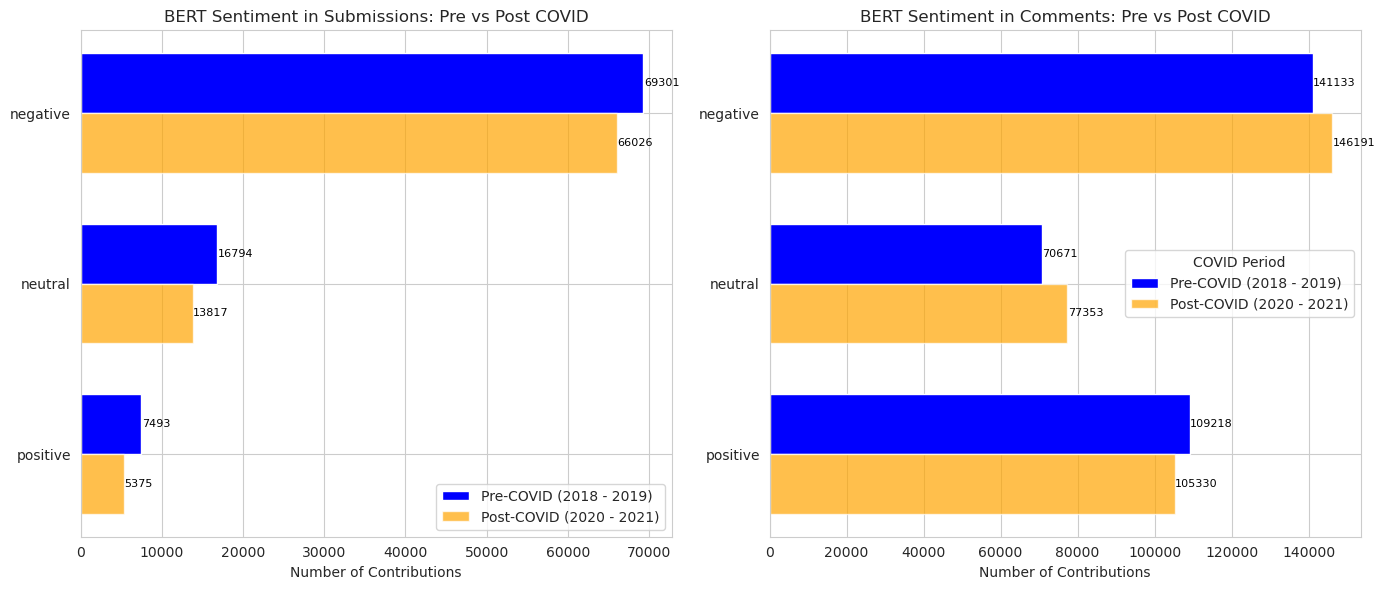

In [314]:
pre_covid_color = 'blue'
post_covid_color = 'orange'
bar_width = 0.35 

# index = [0, 1]  
index = np.arange(3)

plt.figure(figsize=(14, 6))

# Submissions
plt.subplot(1, 2, 1)
pre_bert_counts = sub_pre_df['BERT_label'].value_counts().reindex(['positive', 'neutral', 'negative'], fill_value=0)
post_bert_counts = sub_post_df['BERT_label'].value_counts().reindex(['positive', 'neutral', 'negative'], fill_value=0)

plt.barh([i + bar_width / 2 for i in index], pre_bert_counts.values, bar_width, color=pre_covid_color, label='Pre-COVID (2018 - 2019)')
bars_post_bert = plt.barh([i - bar_width / 2 for i in index], post_bert_counts.values, bar_width, color=post_covid_color, alpha=0.7, label='Post-COVID (2020 - 2021)')

# adding values on bars
for i, value in enumerate(pre_bert_counts.values):
    plt.text(value + 50, index[i] + bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')
for i, value in enumerate(post_bert_counts.values):
    plt.text(value + 50, index[i] - bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')

plt.yticks(index, pre_bert_counts.index)
plt.title('BERT Sentiment in Submissions: Pre vs Post COVID')
plt.xlabel('Number of Contributions')
plt.legend()

# Comments
plt.subplot(1, 2, 2)
pre_bert_counts_com = coms_pre_df['BERT_label'].value_counts().reindex(['positive', 'neutral', 'negative'], fill_value=0)
post_bert_counts_com = coms_post_df['BERT_label'].value_counts().reindex(['positive', 'neutral', 'negative'], fill_value=0)

plt.barh([i + bar_width / 2 for i in index], pre_bert_counts_com.values, bar_width, color=pre_covid_color, label='Pre-COVID (2018 - 2019)')
bars_post_bert_com = plt.barh([i - bar_width / 2 for i in index], post_bert_counts_com.values, bar_width, color=post_covid_color, alpha=0.7, label='Post-COVID (2020 - 2021)')

# adding values on bars
for i, value in enumerate(pre_bert_counts_com.values):
    plt.text(value + 50, index[i] + bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')
for i, value in enumerate(post_bert_counts_com.values):
    plt.text(value + 50, index[i] - bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')

plt.yticks(index, pre_bert_counts_com.index)
plt.title('BERT Sentiment in Comments: Pre vs Post COVID')
plt.xlabel('Number of Contributions')
plt.legend(title="COVID Period")


plt.tight_layout()
plt.savefig('../../work/FCSS/BERT_sentiment_comparison.png', format='png', dpi=300)  # Save as PNG with high resolution
plt.show()

# SAVE FILES (withouth Index and remove Unnamed Columns)

In [146]:
# Submissions
sub_pre_df.loc[:, ~sub_pre_df.columns.str.contains('^Unnamed')].to_csv("../../work/FCSS/submission_pre_covid_sentiment.csv", index=False)
sub_post_df.loc[:, ~sub_post_df.columns.str.contains('^Unnamed')].to_csv("../../work/FCSS/submission_post_covid_sentiment.csv", index=False)

# Comments
coms_pre_df.loc[:, ~coms_pre_df.columns.str.contains('^Unnamed')].to_csv("../../work/FCSS/comments_pre_covid_sentiment.csv", index=False)
coms_post_df.loc[:, ~coms_post_df.columns.str.contains('^Unnamed')].to_csv("../../work/FCSS/comments_post_covid_sentiment.csv", index=False)

In [315]:
coms_post_df

,link_id,subreddit,author,created_utc,permalink,ColumnID,Text,Segment,WC,Analytic,...,Apostro,OtherP,Emoji,VADER_compound,VADER_scaled,BERT_sentiment,BERT_label,BERT_score,VADER_Sentiment,LIWC_Sentiment
0,ei91xe,Anxiety,LemonDread,2020-01-01 00:03:01,/r/Anxiety/comments/ei91xe/continuous_panic_at...,body,"Oh, that sucks.\n\nOh! Low potassium can also ...",1,82,4.45,...,0.00,0.00,0.0,-0.1615,41.925,"(negative, 0.6560449004173279)",negative,0.656045,Neutral,Negative
1,eiarx1,Anxiety,xStillSane,2020-01-01 00:04:24,/r/Anxiety/comments/eiarx1/i_am_not_ready_for_...,body,I can relate so much :( Literally trying to st...,1,15,22.17,...,0.00,26.67,0.0,-0.7251,13.745,"(negative, 0.7477241158485413)",negative,0.747724,Negative,Negative
2,eia5uv,Anxiety,Srtcollinsdarylt,2020-01-01 00:13:19,/r/Anxiety/comments/eia5uv/just_feeling_a_litt...,body,I’ll give you my best advice since i felt the ...,1,47,36.02,...,8.51,0.00,0.0,0.7906,89.530,"(positive, 0.6994567513465881)",positive,0.699457,Positive,Neutral
3,ei91xe,Anxiety,Klynnd2015,2020-01-01 00:15:03,/r/Anxiety/comments/ei91xe/continuous_panic_at...,body,"Thanks for the tip. I managed to eat a little,...",1,51,13.06,...,5.88,0.00,0.0,0.8444,92.220,"(positive, 0.6946948170661926)",positive,0.694695,Positive,Positive
5,ei4t1h,Anxiety,10YB,2020-01-01 00:15:56,/r/Anxiety/comments/ei4t1h/hey/fcoozrp/,body,Whole 2019 i was trying to do something about ...,1,20,1.62,...,0.00,5.00,0.0,-0.7140,14.300,"(negative, 0.9467505812644958)",negative,0.946751,Negative,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392799,lo5uv7,Anxiety,dannydevitofan16,2021-02-21 01:59:01,/r/Anxiety/comments/lo5uv7/its_honestly_baffli...,body,I am both relieved and saddened by how much I ...,1,39,10.19,...,2.56,0.00,0.0,-0.2201,38.995,"(negative, 0.5056665539741516)",negative,0.505667,Neutral,Negative
392800,lol6c6,Anxiety,thechosenjwan,2021-02-21 02:00:25,/r/Anxiety/comments/lol6c6/xanax/go6l8mt/,body,Yup I love it I’m on Xanax and olanzapine for ...,1,35,24.37,...,2.86,0.00,0.0,0.9337,96.685,"(positive, 0.9651636481285095)",positive,0.965164,Positive,Positive
392801,lofl0x,Anxiety,Amendus,2021-02-21 02:01:11,/r/Anxiety/comments/lofl0x/if_i_had_to_choose_...,body,I used to have intense pain in my stomach when...,1,39,10.19,...,5.13,5.13,0.0,-0.7721,11.395,"(negative, 0.9061636328697205)",negative,0.906164,Negative,Negative
392802,lolrhn,Anxiety,mangomelliii,2021-02-21 02:01:18,/r/Anxiety/comments/lolrhn/rabies/go6lc48/,body,thanks. do you know when a rabid dog would sho...,1,57,1.00,...,5.26,0.00,0.0,0.4860,74.300,"(neutral, 0.48613056540489197)",neutral,0.486131,Neutral,Neutral


# Differences in Tone Score

In [316]:
# statistics for comments
comments_pre_stats = coms_pre_df[['BERT_score', 'VADER_compound', 'VADER_scaled', 'Tone']].describe()
comments_post_stats = coms_post_df[['BERT_score', 'VADER_compound', 'VADER_scaled', 'Tone']].describe()

# statistics for submissions
submissions_pre_stats = sub_pre_df[['BERT_score', 'VADER_compound', 'VADER_scaled', 'Tone']].describe()
submissions_post_stats = sub_post_df[['BERT_score', 'VADER_compound', 'VADER_scaled', 'Tone']].describe()

display(comments_pre_stats, comments_post_stats, submissions_pre_stats, submissions_post_stats)

,BERT_score,VADER_compound,VADER_scaled,Tone
count,321022.000000,321022.000000,321022.000000,321022.000000
mean,0.726226,0.227205,61.361393,44.252024
std,0.171615,0.649452,32.475861,41.033536
min,0.334287,-0.999900,0.000000,1.000000
25%,0.575885,-0.381800,30.908091,1.510000
50%,0.734670,0.440400,72.022202,24.610000
75%,0.881371,0.811900,90.599060,94.700000
max,0.992415,0.999900,100.000000,99.000000


,BERT_score,VADER_compound,VADER_scaled,Tone
count,328874.000000,328874.000000,328874.000000,328874.000000
mean,0.728045,0.225839,61.291928,43.997637
std,0.169162,0.645772,32.288607,40.970430
min,0.334712,-0.999900,0.005000,1.000000
25%,0.581793,-0.381800,30.910000,1.400000
50%,0.740114,0.440400,72.020000,20.230000
75%,0.879726,0.802000,90.100000,94.700000
max,0.992441,1.000000,100.000000,99.000000


,BERT_score,VADER_compound,VADER_scaled,Tone
count,93588.000000,93588.000000,93588.000000,93588.000000
mean,0.732958,-0.255919,37.202764,15.025346
std,0.144682,0.747245,37.365967,24.333427
min,0.336919,-0.999900,0.000000,1.000000
25%,0.616777,-0.931600,3.415342,1.000000
50%,0.758347,-0.613600,19.316932,2.960000
75%,0.857902,0.548625,77.433993,20.230000
max,0.991827,0.999900,100.000000,99.000000


,BERT_score,VADER_compound,VADER_scaled,Tone
count,85218.000000,85218.000000,85218.000000,85218.000000
mean,0.739197,-0.266912,36.654384,13.946451
std,0.142378,0.747237,37.361826,23.488955
min,0.336097,-1.000000,0.000000,1.000000
25%,0.627334,-0.933100,3.345000,1.000000
50%,0.767325,-0.640800,17.960000,2.350000
75%,0.860935,0.542300,77.115000,16.190000
max,0.991192,1.000000,100.000000,99.000000


In [288]:
print(sub_pre_df['VADER_compound'].var(), sub_post_df['VADER_compound'].var())
print(coms_pre_df['VADER_compound'].var(), coms_post_df['VADER_compound'].var())

print(sub_pre_df['Tone'].var(), sub_post_df['Tone'].var())
print(coms_pre_df['Tone'].var(), coms_post_df['Tone'].var())

print(sub_pre_df[['VADER_compound', 'Tone']].isnull().sum())
print(sub_post_df[['VADER_compound', 'Tone']].isnull().sum())

print(coms_pre_df[['VADER_compound', 'Tone']].isnull().sum())
print(coms_post_df[['VADER_compound', 'Tone']].isnull().sum())

0.5583745123408419 0.5583624317235505
0.4217882562404532 0.41702164657754853
592.1156640169893 551.7309859568359
1683.7511056289193 1678.5761751535413
VADER_compound    0
Tone              0
dtype: int64
VADER_compound    0
Tone              0
dtype: int64
VADER_compound    0
Tone              0
dtype: int64
VADER_compound    0
Tone              0
dtype: int64


# Correlations

In [317]:
display(sub_pre_df[['BERT_score', 'VADER_compound', 'VADER_scaled', 'Tone']].corr())
display(sub_post_df[['BERT_score', 'VADER_compound', 'VADER_scaled', 'Tone']].corr())
display(coms_post_df[['BERT_score', 'VADER_compound', 'VADER_scaled', 'Tone']].corr())
display(coms_pre_df[['BERT_score', 'VADER_compound', 'VADER_scaled', 'Tone']].corr())

,BERT_score,VADER_compound,VADER_scaled,Tone
BERT_score,1.000000,-0.230972,-0.230972,-0.118923
VADER_compound,-0.230972,1.000000,1.000000,0.545325
VADER_scaled,-0.230972,1.000000,1.000000,0.545325
Tone,-0.118923,0.545325,0.545325,1.000000


,BERT_score,VADER_compound,VADER_scaled,Tone
BERT_score,1.000000,-0.258996,-0.258996,-0.156605
VADER_compound,-0.258996,1.000000,1.000000,0.538708
VADER_scaled,-0.258996,1.000000,1.000000,0.538708
Tone,-0.156605,0.538708,0.538708,1.000000


,BERT_score,VADER_compound,VADER_scaled,Tone
BERT_score,1.000000,-0.028515,-0.028515,0.190513
VADER_compound,-0.028515,1.000000,1.000000,0.597354
VADER_scaled,-0.028515,1.000000,1.000000,0.597354
Tone,0.190513,0.597354,0.597354,1.000000


,BERT_score,VADER_compound,VADER_scaled,Tone
BERT_score,1.000000,-0.000583,-0.000583,0.215302
VADER_compound,-0.000583,1.000000,1.000000,0.612006
VADER_scaled,-0.000583,1.000000,1.000000,0.612006
Tone,0.215302,0.612006,0.612006,1.000000


# Mann-Whitney U Test (non-parametric) and t-test (parametric) for pre vs. post.

In [318]:
def test_sentiment(df_pre, df_post, columns, test_type='mannwhitney'):
    for column in columns:
        if test_type == 'mannwhitney':
            u_stat, p_value = mannwhitneyu(df_pre[column].dropna(), df_post[column].dropna(), alternative='two-sided')
            print(f"Mann-Whitney U Test for {column}: u-stat={u_stat}, p-value={p_value}")
        elif test_type == 'ttest':
            t_stat, p_value = ttest_ind(df_pre[column].dropna(), df_post[column].dropna(), equal_var=False)
            print(f"T-test for {column}: t-stat={t_stat}, p-value={p_value}")

sentiment_columns = ['BERT_score', 'VADER_compound', 'VADER_scaled', 'Tone']

test_sentiment(sub_pre_df, sub_post_df, sentiment_columns, 'mannwhitney')
test_sentiment(coms_pre_df, coms_post_df, sentiment_columns, 'mannwhitney')

test_sentiment(sub_pre_df, sub_post_df, sentiment_columns, 'ttest')
test_sentiment(coms_pre_df, coms_post_df, sentiment_columns, 'ttest')

Mann-Whitney U Test for BERT_score: u-stat=3891737480.0, p-value=1.3433670969212316e-18
Mann-Whitney U Test for VADER_compound: u-stat=4020277297.5, p-value=0.0027969939975342646
Mann-Whitney U Test for VADER_scaled: u-stat=4019538960.0, p-value=0.0034837203264725877
Mann-Whitney U Test for Tone: u-stat=4122789752.0, p-value=1.6873825713814459e-37
Mann-Whitney U Test for BERT_score: u-stat=52519287043.5, p-value=0.00038194074941618627
Mann-Whitney U Test for VADER_compound: u-stat=53007685281.5, p-value=0.0036528930713773736
Mann-Whitney U Test for VADER_scaled: u-stat=53024447871.5, p-value=0.001757900077741547
Mann-Whitney U Test for Tone: u-stat=52940283939.5, p-value=0.04148068990806008
T-test for BERT_score: t-stat=-9.182602990176024, p-value=4.25122694118072e-20
T-test for VADER_compound: t-stat=3.107051802928367, p-value=0.001889931282435111
T-test for VADER_scaled: t-stat=3.099670186757909, p-value=0.0019376657400813845
T-test for Tone: t-stat=9.535735803182261, p-value=1.50600

# Test with Sampling

In [319]:
def test_sentiment_with_sampling(df_pre, df_post, columns, test_type='mannwhitney', sample_size=10000):
    for column in columns:
        pre_samples = df_pre[column].dropna()
        post_samples = df_post[column].dropna()
        
        if len(pre_samples) > sample_size:
            pre_samples = pre_samples.sample(sample_size, random_state=42)
        else:
            pre_samples = pre_samples.sample(sample_size, replace=True, random_state=42)
        
        if len(post_samples) > sample_size:
            post_samples = post_samples.sample(sample_size, random_state=42)
        else:
            post_samples = post_samples.sample(sample_size, replace=True, random_state=42)

        if test_type == 'mannwhitney':
            u_stat, p_value = mannwhitneyu(pre_samples, post_samples, alternative='two-sided')
            print(f"Mann-Whitney U Test for {column}: u-stat={u_stat}, p-value={p_value}")
        elif test_type == 'ttest':
            t_stat, p_value = ttest_ind(pre_samples, post_samples, equal_var=False)
            print(f"T-test for {column}: t-stat={t_stat}, p-value={p_value}")

sentiment_columns = ['BERT_score', 'VADER_compound', 'VADER_scaled', 'Tone']

print("Submissions:")
test_sentiment_with_sampling(sub_pre_df, sub_post_df, sentiment_columns, 'mannwhitney')
test_sentiment_with_sampling(sub_pre_df, sub_post_df, sentiment_columns, 'ttest')

print("\nComments:")
test_sentiment_with_sampling(coms_pre_df, coms_post_df, sentiment_columns, 'mannwhitney')
test_sentiment_with_sampling(coms_pre_df, coms_post_df, sentiment_columns, 'ttest')

Submissions:
Mann-Whitney U Test for BERT_score: u-stat=48147043.0, p-value=5.660626216977043e-06
Mann-Whitney U Test for VADER_compound: u-stat=50396799.0, p-value=0.3310854749779585
Mann-Whitney U Test for VADER_scaled: u-stat=50387173.0, p-value=0.3429505804591273
Mann-Whitney U Test for Tone: u-stat=51747504.0, p-value=1.0089485708708885e-05
T-test for BERT_score: t-stat=-4.9921812871633655, p-value=6.020358823300749e-07
T-test for VADER_compound: t-stat=1.257677117804703, p-value=0.20852323686114366
T-test for VADER_scaled: t-stat=1.2552624979814189, p-value=0.20939815200519735
T-test for Tone: t-stat=3.0993104000028344, p-value=0.0019424113224287493

Comments:
Mann-Whitney U Test for BERT_score: u-stat=49535062.5, p-value=0.25477407123501505
Mann-Whitney U Test for VADER_compound: u-stat=49698334.5, p-value=0.4599619483180528
Mann-Whitney U Test for VADER_scaled: u-stat=49712112.0, p-value=0.4807103357428648
Mann-Whitney U Test for Tone: u-stat=49441134.5, p-value=0.1660086975423

# Effect Size Cohen's D

In [321]:
def cohen_d(x, y):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    std_x = np.std(x, ddof=1)
    std_y = np.std(y, ddof=1)
    pooled_std = np.sqrt((std_x ** 2 + std_y ** 2) / 2)
    return (mean_x - mean_y) / pooled_std

# BERT_score
bert_score_d_sub = cohen_d(sub_pre_df['BERT_score'].dropna(), sub_post_df['BERT_score'].dropna())
bert_score_d_com = cohen_d(coms_pre_df['BERT_score'].dropna(), coms_post_df['BERT_score'].dropna())
print("Cohen's d for BERT_score (Submissions):", bert_score_d_sub)
print("Cohen's d for BERT_score (Comments):", bert_score_d_com)

# VADER_compound
vader_compound_d_sub = cohen_d(sub_pre_df['VADER_compound'].dropna(), sub_post_df['VADER_compound'].dropna())
vader_compound_d_com = cohen_d(coms_pre_df['VADER_compound'].dropna(), coms_post_df['VADER_compound'].dropna())
print("Cohen's d for VADER_compound (Submissions):",  vader_compound_d_sub)
print("Cohen's d for VADER_compound (Comments):", vader_compound_d_com)

# VADER_scaled
vader_scaled_d_sub = cohen_d(sub_pre_df['VADER_scaled'].dropna(), sub_post_df['VADER_scaled'].dropna())
vader_scaled_d_com = cohen_d(coms_pre_df['VADER_scaled'].dropna(), coms_post_df['VADER_scaled'].dropna())
print("Cohen's d for VADER_scaled (Submissions):", vader_scaled_d_sub)
print("Cohen's d for VADER_scaled (Comments):", vader_scaled_d_com)

# Tone
tone_d_sub = cohen_d(sub_pre_df['Tone'].dropna(), sub_post_df['Tone'].dropna())
tone_d_com = cohen_d(coms_pre_df['Tone'].dropna(), coms_post_df['Tone'].dropna())
print("Cohen's d for Tone (Submissions):", tone_d_sub)
print("Cohen's d for Tone (Comments):", tone_d_com)

Cohen's d for BERT_score (Submissions): -0.043462822430685645
Cohen's d for BERT_score (Comments): -0.010673909192179106
Cohen's d for VADER_compound (Submissions): 0.014711727642521202
Cohen's d for VADER_compound (Comments): 0.0021101686631526924
Cohen's d for VADER_scaled (Submissions): 0.014676741723214943
Cohen's d for VADER_scaled (Comments): 0.0021451476676415367
Cohen's d for Tone (Submissions): 0.04511389531197096
Cohen's d for Tone (Comments): 0.0062042450216858525


In [291]:
most_negative_tone = sub_post_df.sort_values(by='Tone', ascending=True).head(100)
most_negative_vader = sub_post_df.sort_values(by='VADER_scaled', ascending=True).head(100)

In [271]:
most_negative_tone[['Text', 'Tone']].sample().values

array([['How can I calm down?\nTomorrow I’m rapping for my band at my youth group at my church. I’m so freaking nervous and I’m nervous I’ll mess up. How can I calm down???',
        1.0]], dtype=object)

In [276]:
most_negative_vader[['Text', 'VADER_scaled']].sample().values

array([['Tired of "I\'m just tired".\nI dont even know where to begin. For starters I suppose, I hate talking about.my issues, but I\'ve also never been accused of being under thorough. So here goes... \n\nA quick(ish) bio and back story: \n\nI\'m 28 years old, divorced, college drop out who graduated trade school with flying colors. I have a mortgage, truck payment, along with way more vehicles than any one person ought to have. Im in decent(ish) amounts of debt, but im managing?... \n\nAnyway\n\nMy parents separated when I was 5. I cant tell you a memory prior to the day my dad and I left. There\'s just nothing, no trace memories, no happy little glimpses of a family. Hell, for all I know, I was grown in a damn test tube and released at the age of 5 with a blank slate. (I know thats not the case, ive seen plenty of old home videos/pictures.) My mother was in and out of my life a few times over the course of the next 12 or so years. My dad drove big rigs alot while I was growing up. S

# Final Plot